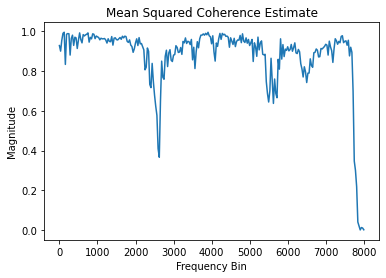

torch.Size([257])


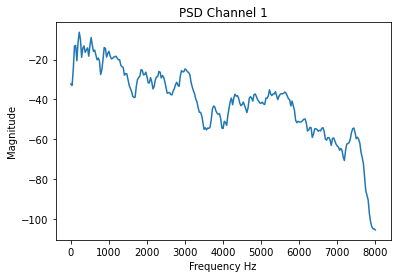

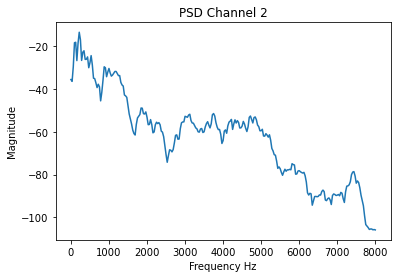

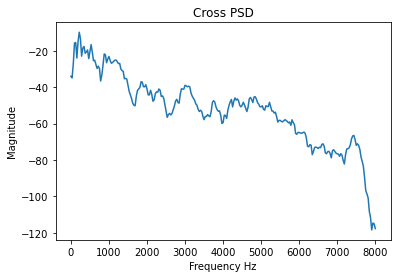

In [20]:
import math
import torch
import torch.fft as fft
import matplotlib.pyplot as plt
import random
import torchaudio

import math

def welch_periodogram(signal, segment_length, overlap, window_function=None):
    signal_length = len(signal)
    step_size = segment_length - overlap
    num_segments = (signal_length - overlap) // step_size

    # Define a window function if not provided
    if window_function is None:
        window_function = [1.0] * segment_length  # Rectangular window (no window)

    # Initialize the result PSD array
    psd = [0.0] * (segment_length // 2)

    # Iterate over segments and compute their periodograms
    for i in range(num_segments):
        start = i * step_size
        end = start + segment_length

        # Apply the window function to the segment
        windowed_segment = [signal[j] * window_function[j - start] for j in range(start, end)]

        # Compute the DFT of the windowed segment
        dft_real = [0.0] * (segment_length // 2)
        dft_imag = [0.0] * (segment_length // 2)

        for k in range(segment_length // 2):
            for n in range(segment_length):
                angle = 2.0 * math.pi * k * n / segment_length
                dft_real[k] += windowed_segment[n] * math.cos(angle)
                dft_imag[k] -= windowed_segment[n] * math.sin(angle)

        # Calculate the periodogram for this segment
        periodogram = [(dft_real[k] ** 2 + dft_imag[k] ** 2) / segment_length for k in range(segment_length // 2)]

        # Add the segment's periodogram to the overall result
        for j in range(segment_length // 2):
            psd[j] += periodogram[j]

    # Average the periodograms over all segments
    for j in range(segment_length // 2):
        psd[j] /= num_segments

    return psd

# Example usage


def welch_cross_spectral_density(signal1, signal2, segment_length, overlap, window_function=None, nfft=None, sampling_frequency=16000):
    assert len(signal1) == len(signal2), "Input signals must have the same length."

    signal_length = len(signal1)
    step_size = segment_length - overlap
    num_segments = (signal_length - overlap) // step_size

    # Calculate the sampling period
    sampling_period = 1 / sampling_frequency

    # Use segment_length as nfft if not provided
    if nfft is None:
        nfft = segment_length

    # Define a window function if not provided
    if window_function is None:
        window_function = torch.ones(segment_length)

    # Initialize the result CSD tensor
    csd = torch.zeros(nfft // 2 + 1)
    csd = torch.complex(csd,csd)

    # Iterate over segments and compute their cross-spectral densities
    for i in range(num_segments):
        start = i * step_size
        end = start + segment_length

        # Apply the window function to the segments
        windowed_segment1 = signal1[start:end] * window_function
        windowed_segment2 = signal2[start:end] * window_function

        # Compute the FFT of the windowed segments
        fft_result1 = fft.rfft(windowed_segment1, n=nfft)
        fft_result2 = fft.rfft(windowed_segment2, n=nfft)

        # Compute the cross-spectral density for this segment
        csd_segment = (fft_result1 * fft_result2.conj()) / nfft

        # Add the segment's cross-spectral density to the overall result
        csd += csd_segment[:nfft // 2+1]

    # Average the cross-spectral densities over all segments
    csd /= num_segments

    return csd

def mean_squared_coherence(signal1, signal2, segment_length, overlap, window_function=None, nfft=None, sampling_frequency=16000):
    # Compute the cross-spectral density using Welch's method
    csd = welch_cross_spectral_density(signal1, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)

    # Compute the power spectral densities of the individual signals
    psd1 = welch_cross_spectral_density(signal1, signal1, segment_length, overlap, window_function, nfft, sampling_frequency)
    psd2 = welch_cross_spectral_density(signal2, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)

    # Compute the Mean Squared Coherence
    msc = (torch.abs(csd) ** 2) / ((psd1 * psd2))

    return msc

# Example usage
if __name__ == "__main__":
    # Generate two random signals for testing
    # signal_length = 1000
    # signal1 = torch.tensor([random.random() for _ in range(signal_length)])
    # signal2 = torch.tensor([random.random() for _ in range(signal_length)])
    
    # bin_sig,sample_rate = torchaudio.load('/Users/vtokala/Documents/Research/Databases/Dataset_Binaural_2S/iso_wgn.wav')
    bin_sig,sample_rate = torchaudio.load('/Users/vtokala/Documents/Research/di_nn/Dataset/clean_trainset_1f/p226_014_2.wav')
    signal1 = bin_sig[0,:]
    signal2 = bin_sig[1,:]
    signal1 = signal1.squeeze()
    signal2 = signal2.squeeze()
    # Parameters for Welch's method
    segment_length = 512
    overlap = 300
    # window_function = 0.54 - 0.46 * torch.cos(2 * math.pi * torch.arange(segment_length) / (segment_length - 1))
    window_function = torch.hann_window(segment_length)

    # Specify the desired nfft value (e.g., 256)
    nfft = 512

    # Specify the sampling frequency (16,000 Hz)
    sampling_frequency = 16000

    # Compute the Mean Squared Coherence with the specified nfft and sampling frequency
    psd1 = welch_cross_spectral_density(signal1, signal1, segment_length, overlap, window_function, nfft, sampling_frequency)
    psd2 = welch_cross_spectral_density(signal2, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)
    # psd1 = welch_periodogram(signal1, segment_length, overlap, window_function)
    cpsd = welch_cross_spectral_density(signal1, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)
    msc = mean_squared_coherence(signal1, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)
    frequency_axis = torch.linspace(0, sample_rate / 2, msc.size(0))
    # Plot the resulting Mean Squared Coherence
    plt.figure()
    plt.plot(frequency_axis,(msc.abs()))
    plt.title("Mean Squared Coherence Estimate")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.show()
    print(msc.shape)
    plt.figure()
    plt.plot(frequency_axis,10*torch.log10(psd1.abs()))
    plt.title("PSD Channel 1")
    plt.xlabel("Frequency Hz")
    plt.ylabel("Magnitude")
    plt.show()
    
    plt.figure()
    plt.plot(frequency_axis,10*torch.log10(psd2.abs()))
    plt.title("PSD Channel 2")
    plt.xlabel("Frequency Hz")
    plt.ylabel("Magnitude")
    plt.show()
    
    plt.figure()
    plt.plot(frequency_axis,10*torch.log10(cpsd.abs()))
    plt.title("Cross PSD")
    plt.xlabel("Frequency Hz")
    plt.ylabel("Magnitude")
    plt.show()

In [21]:
cpsd

tensor([ 3.9103e-04+0.0000e+00j,  3.0199e-04+1.1580e-04j,
         5.4810e-04+1.8182e-03j,  3.4951e-03+2.5864e-02j,
         2.7596e-03+2.7996e-02j, -1.4165e-03+3.6864e-03j,
        -2.5988e-02+1.7627e-02j, -9.1640e-02+4.7010e-02j,
        -4.2645e-02+1.7249e-02j, -4.9075e-03-9.4307e-04j,
        -1.0658e-02-8.7225e-03j, -1.1006e-02-1.3149e-02j,
        -2.9934e-03-6.5907e-03j,  4.4243e-04-8.5149e-03j,
         2.5797e-03-1.0627e-02j,  1.9467e-03-3.1127e-03j,
         8.4789e-03-3.1960e-03j,  2.0756e-02-5.8436e-03j,
         8.1267e-03-1.4358e-03j,  2.7894e-03+2.7907e-04j,
         3.0003e-03+2.3039e-04j,  1.7852e-03+3.4170e-04j,
         9.8170e-04+3.8981e-04j,  1.1409e-03+8.2550e-04j,
         7.9365e-04+6.8964e-04j,  1.2387e-04+1.7798e-04j,
         6.8149e-05+4.5635e-04j, -2.5928e-04+1.5879e-03j,
        -2.7852e-03+6.0091e-03j, -3.0719e-03+5.1430e-03j,
        -1.6779e-03+1.4173e-03j, -3.2951e-03+1.2573e-03j,
        -4.7471e-03+7.7042e-04j, -2.8922e-03-4.0559e-04j,
        -1.784

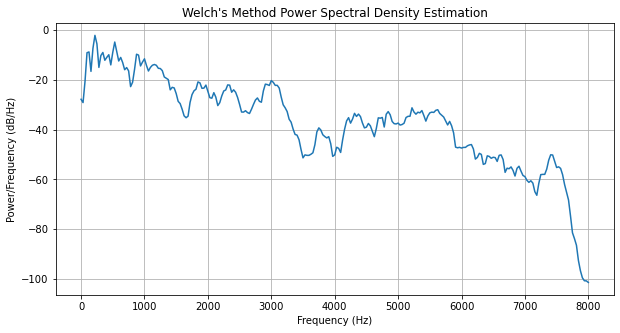

In [22]:
import torch
import torch.fft as fft
import matplotlib.pyplot as plt

# Generate a sample signal (you should replace this with your actual signal)
sampling_rate = 16000
t = torch.arange(0, 1, 1/sampling_rate)
bin_sig,sample_rate = torchaudio.load('/Users/vtokala/Documents/Research/di_nn/Dataset/clean_trainset_1f/p226_014_2.wav')
signal = bin_sig[0,:]
signal2 = bin_sig[1,:]
signal1 = signal1.squeeze()
signal2 = signal2.squeeze()

# Parameters for Welch's method
nfft = 512
window_size = nfft  # You can choose a different window size if needed
overlap = window_size // 2  # 50% overlap

# Apply Hanning window
window = torch.hann_window(window_size)

# Compute the number of segments
n_segments = (len(signal) - overlap) // (window_size - overlap)

# Initialize an array to store the periodograms
periodograms = []

# Compute the periodogram for each segment
for i in range(n_segments):
    start = i * (window_size - overlap)
    end = start + window_size
    segment = signal[start:end]

    # Apply the Hanning window
    windowed_segment = segment * window

    # Compute the FFT
    fft_result = fft.fft(windowed_segment, n=nfft)

    # Compute the periodogram (squared magnitude of the FFT)
    periodogram = torch.abs(fft_result)**2

    # Store the periodogram
    periodograms.append(periodogram)

# Average the periodograms
average_periodogram = torch.mean(torch.stack(periodograms), dim=0)

# Normalize the periodogram
normalized_periodogram = average_periodogram / torch.sum(window**2)

# Frequency axis
frequency_axis = torch.linspace(0, sampling_rate / 2, nfft // 2 + 1)

# Plot the normalized periodogram
plt.figure(figsize=(10, 5))
plt.plot(frequency_axis, 10 * torch.log10(normalized_periodogram[:nfft // 2 + 1]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Welch\'s Method Power Spectral Density Estimation')
plt.grid(True)
plt.show()


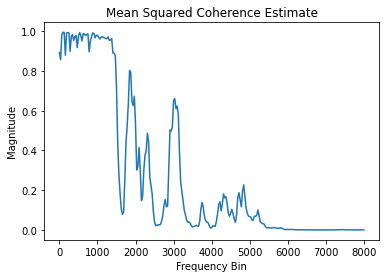

torch.Size([257])


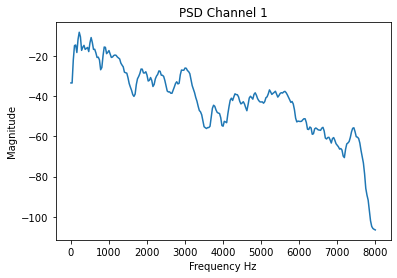

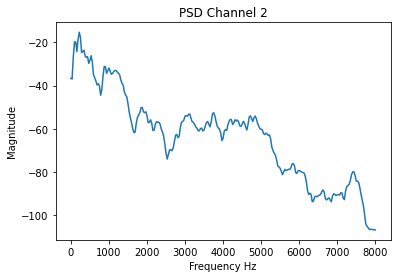

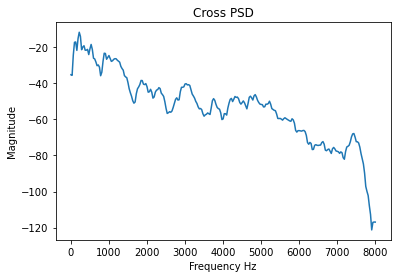

In [23]:
import math
import torch
import torch.fft as fft
import matplotlib.pyplot as plt
import random
import torchaudio
import warnings
warnings.filterwarnings('error')

def welch_cross_spectral_density(signal1, signal2, segment_length, overlap, window_function=None, nfft=None, sampling_frequency=16000):
    assert len(signal1) == len(signal2), "Input signals must have the same length."

    signal_length = len(signal1)
    step_size = segment_length - overlap
    num_segments = (signal_length - overlap) // step_size

    # Calculate the sampling period
    sampling_period = 1 / sampling_frequency

    # Use segment_length as nfft if not provided
    if nfft is None:
        nfft = segment_length

    # Define a window function if not provided
    if window_function is None:
        window_function = torch.ones(segment_length)

    # Initialize the result CSD tensor
    csd = torch.zeros(nfft // 2 + 1)
    csd = torch.complex(csd,csd)

    # Iterate over segments and compute their cross-spectral densities
    for i in range(num_segments):
        start = i * step_size
        end = start + segment_length

        # Apply the window function to the segments
        windowed_segment1 = signal1[start:end] * window_function
        windowed_segment2 = signal2[start:end] * window_function

        # Compute the FFT of the windowed segments
        fft_result1 = fft.rfft(windowed_segment1, n=nfft)
        fft_result2 = fft.rfft(windowed_segment2, n=nfft)
        # breakpoint()
        # Compute the cross-spectral density for this segment
        csd_segment = (fft_result1 * fft_result2.conj()) / nfft

        # Add the segment's cross-spectral density to the overall result
        csd += csd_segment[:nfft // 2+1]

    # Average the cross-spectral densities over all segments
    csd /= num_segments

    return csd

def mean_squared_coherence(signal1, signal2, segment_length, overlap, window_function=None, nfft=None, sampling_frequency=16000):
    # Compute the cross-spectral density using Welch's method
    csd = welch_cross_spectral_density(signal1, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)

    # Compute the power spectral densities of the individual signals
    psd1 = welch_cross_spectral_density(signal1, signal1, segment_length, overlap, window_function, nfft, sampling_frequency)
    psd2 = welch_cross_spectral_density(signal2, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)

    # Compute the Mean Squared Coherence
    # msc = (torch.abs(csd) ** 2) / ((psd1 * psd2)+1e-8)
    msc = csd/torch.sqrt(((psd1 * psd2)+1e-8))

    return msc

# Example usage
if __name__ == "__main__":
    # Generate two random signals for testing
    # signal_length = 1000
    # signal1 = torch.tensor([random.random() for _ in range(signal_length)])
    # signal2 = torch.tensor([random.random() for _ in range(signal_length)])
    
    # bin_sig,sample_rate = torchaudio.load('/Users/vtokala/Documents/Research/Databases/Dataset_Binaural_2S/iso_wgn.wav')
    bin_sig,sample_rate = torchaudio.load('/Users/vtokala/Documents/Research/di_nn/Dataset/clean_trainset_1f/p226_014_2.wav')
    signal1 = bin_sig[0,:]
    signal2 = bin_sig[1,:]
    signal1 = signal1.squeeze()
    signal2 = signal2.squeeze()
    # Parameters for Welch's method
    segment_length = 400
    overlap = 300
    # window_function = 0.54 - 0.46 * torch.cos(2 * math.pi * torch.arange(segment_length) / (segment_length - 1))
    window_function = torch.hann_window(segment_length)

    # Specify the desired nfft value (e.g., 256)
    nfft = 512

    # Specify the sampling frequency (16,000 Hz)
    sampling_frequency = 16000

    # Compute the Mean Squared Coherence with the specified nfft and sampling frequency
    psd1 = welch_cross_spectral_density(signal1, signal1, segment_length, overlap, window_function, nfft, sampling_frequency)
    psd2 = welch_cross_spectral_density(signal2, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)
    cpsd = welch_cross_spectral_density(signal1, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)
    msc = mean_squared_coherence(signal1, signal2, segment_length, overlap, window_function, nfft, sampling_frequency)
    frequency_axis = torch.linspace(0, sample_rate / 2, msc.size(0))
    # Plot the resulting Mean Squared Coherence
    
    # breakpoint()
    plt.figure(1)
    plt.plot(frequency_axis,(msc.abs()))
    plt.title("Mean Squared Coherence Estimate")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.show()
    print(cpsd.shape)
    plt.figure(3)
    plt.plot(frequency_axis,10*torch.log10(psd1.abs()))
    plt.title("PSD Channel 1")
    plt.xlabel("Frequency Hz")
    plt.ylabel("Magnitude")
    plt.show()
    
    plt.figure(4)
    plt.plot(frequency_axis,10*torch.log10(psd2.abs()))
    plt.title("PSD Channel 2")
    plt.xlabel("Frequency Hz")
    plt.ylabel("Magnitude")
    plt.show()
    
    plt.figure(5)
    plt.plot(frequency_axis,10*torch.log10(cpsd.abs()))
    plt.title("Cross PSD")
    plt.xlabel("Frequency Hz")
    plt.ylabel("Magnitude")
    plt.show()